Alexander W. Criswell 10/2/25

Now that we have implemented the updated poisson-gamma selection term, let's test it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
xp.cuda.is_available()

True

In [5]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [6]:
if bool(int(os.environ['PELARGIR_GPU'])):
    print('GPU enabled.')

GPU enabled.


In [7]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


Using the same seed as before, because it does result in a valid initialization state.

In [8]:
test_rng = xp.random.default_rng(170817)

In [9]:
test_prior = GalacticBinaryPrior(test_rng)

In [10]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [11]:
samps = test_prior.sample_conditional(int(1e7))

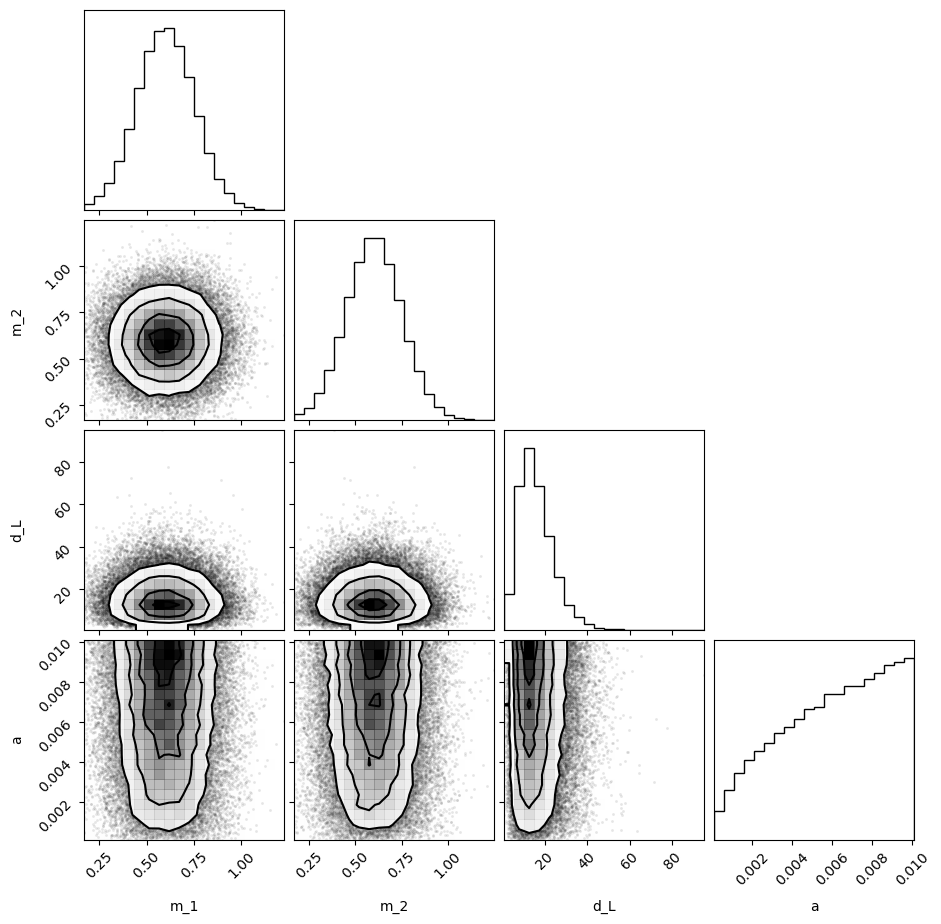

In [15]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [16]:
amps, fgws = get_amp_freq(samps)

In [17]:
test_hprior = PopulationHyperPrior(test_rng)

In [18]:
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0)

In [19]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [20]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [21]:
data_N_res

array(923)

In [22]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':data_N_res}

In [23]:
test_popmodel.construct_likelihood(datadict)

In [24]:
test_popmodel.Nsamp = 20
chain_out, fs, specs, Ns = test_popmodel.sample_likelihood(save_spec=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


In [25]:
L_mask = [True if not xp.isinf(L) else False for L in chain_out[-1,:] ]

In [26]:
L_mask

[True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False]

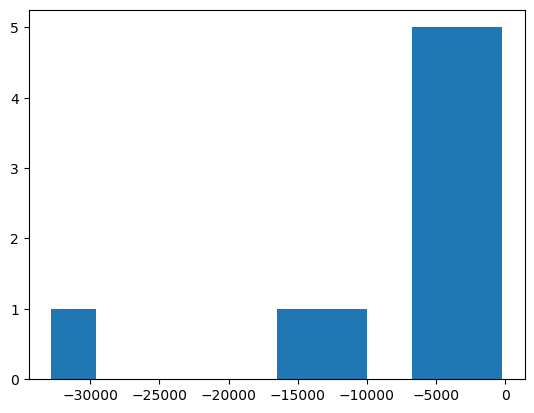

In [27]:
plt.figure()
plt.hist([L for L in chain_out[-1,:].get() if not xp.isinf(L) ])
plt.show()

In [28]:
xp.argmax(chain_out[-1,:])

array(12)

In [29]:
chain_out[-1,:]

array([ -4363.13558766,  -5984.01108781, -10129.82486336,            -inf,
                  -inf,            -inf,  -2621.67458905,            -inf,
        -6687.0217116 , -32821.4861869 ,  -3084.22945984,   -410.52148111,
         -226.10952534,  -6054.02285508,   -757.93810002,  -3936.97641144,
                  -inf,            -inf, -14792.77244667,            -inf])

In [30]:
Ns

[array(19),
 array(81),
 array(1351),
 array(17574),
 array(5296),
 array(14376),
 array(20),
 array(16124),
 array(169),
 array(11968),
 array(5183),
 array(2180),
 array(1797),
 array(1653),
 array(189),
 array(7912),
 array(9094),
 array(5639),
 array(3943),
 array(8241)]

In [31]:
xp.asarray(Ns)[xp.argmax(chain_out[-1,:])]

array(1797)

In [32]:
xp.array(Ns)[[not L for L in L_mask]]

array([17574,  5296, 14376, 16124,  9094,  5639,  8241])

In [33]:
[key for key in test_hprior.hyperprior_dict.keys()]

['m_mu', 'm_sigma', 'd_gamma_a', 'd_gamma_b', 'a_alpha']

In [34]:
chain_out[:-1,:][:,[not L for L in L_mask]].T

array([[0.65177796, 0.21383688, 1.44160927, 6.32774038, 1.11365719],
       [0.56760633, 0.08549405, 3.31976635, 6.62910414, 1.03158724],
       [0.61039986, 0.27138691, 1.17833942, 2.56062233, 0.7677545 ],
       [0.47109397, 0.45373058, 1.77379665, 4.38166872, 1.05267707],
       [0.60091585, 0.43365417, 1.67316321, 1.00512297, 0.81915023],
       [0.63408041, 0.11793603, 4.15392435, 2.90811665, 1.09685356],
       [0.53022797, 0.6555803 , 5.65294497, 3.66686186, 1.14081334]])

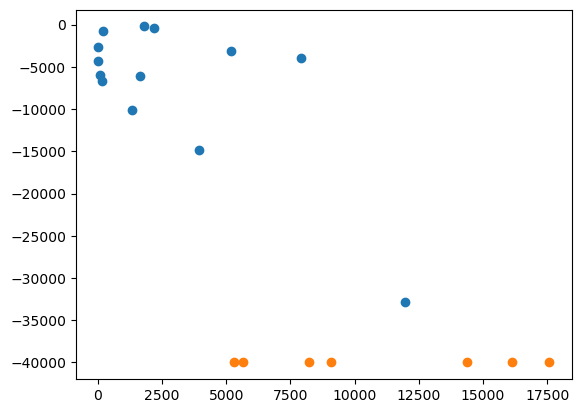

In [35]:
plt.scatter(np.array(Ns)[L_mask],chain_out[-1,:].get()[L_mask])
inf_Ls = np.array(Ns)[[not L for L in L_mask]]
plt.scatter(inf_Ls,np.repeat(-40000,len(inf_Ls)))

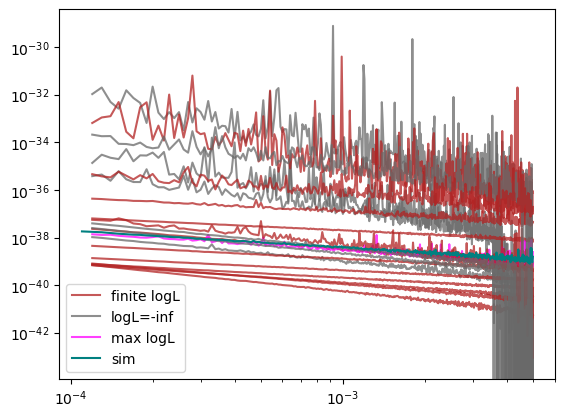

In [36]:
plt.figure()
finite_label_count = 0
inf_label_count = 0
for i in range(test_popmodel.Nsamp):
    if L_mask[i]:
        color='firebrick'
        if i==xp.argmax(chain_out[-1,:]):
            color='magenta'
            label='max logL'
        else:
            if finite_label_count == 0:
                label='finite logL'
                finite_label_count +=1
            else:
                label='__nolabel__'
    else:
        color='dimgrey'
        if inf_label_count == 0:
            label='logL=-inf'
            inf_label_count +=1
        else:
            label='__nolabel__'
        
    plt.loglog(fs, specs[i],label=label,c=color,alpha=0.75)
plt.loglog(test_f.get(),data_fg.get(),label='sim',c='teal')
plt.legend()
plt.show()

In [37]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [38]:
test_mus = np.linspace(0.5,0.7,10)

In [39]:
likes = []
for tm in test_mus:
    scan_theta['m_mu'] = xp.array(tm)
    likes.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

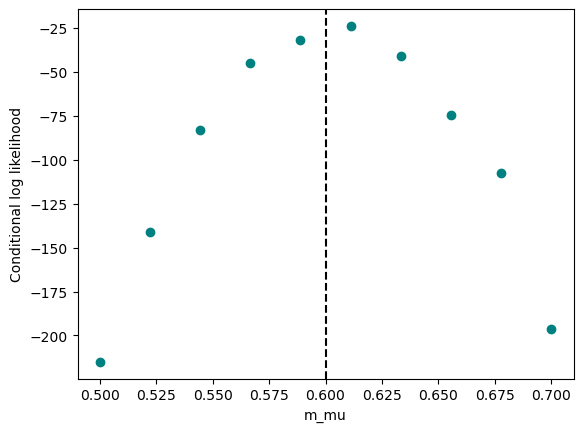

In [40]:
plt.figure()
plt.scatter(test_mus,likes,color='teal')
plt.axvline(pop_theta['m_mu'].get(),color='k',ls='--')
plt.xlabel("m_mu")
plt.ylabel("Conditional log likelihood")
plt.show()

Okay now for the other variables:

In [41]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [42]:
test_sigmas = np.linspace(0,0.5,10)

In [43]:
likes_sigma = []
for ts in test_sigmas:
    scan_theta['m_sigma'] = xp.array(ts)
    likes_sigma.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

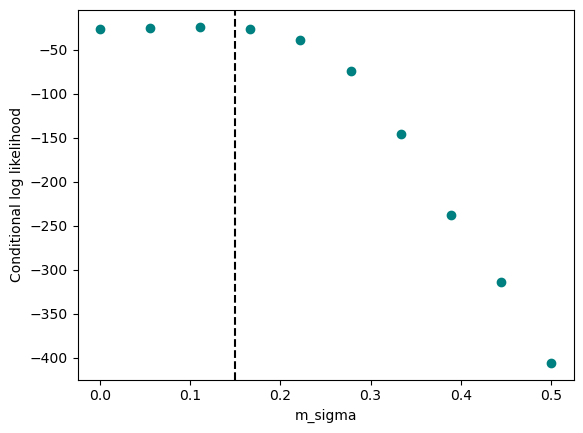

In [44]:
plt.figure()
plt.scatter(test_sigmas,likes_sigma,color='teal')
plt.axvline(pop_theta['m_sigma'].get(),color='k',ls='--')
plt.xlabel("m_sigma")
plt.ylabel("Conditional log likelihood")
plt.show()

In [45]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [46]:
test_dga = np.linspace(0,10,10)

In [47]:
likes_dga = []
for tda in test_dga:
    scan_theta['d_gamma_a'] = xp.array(tda)
    likes_dga.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

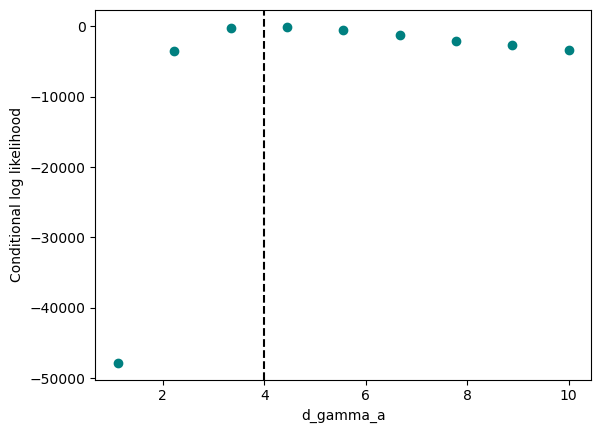

In [48]:
plt.figure()
plt.scatter(test_dga,likes_dga,color='teal')
plt.axvline(pop_theta['d_gamma_a'].get(),color='k',ls='--')
plt.xlabel("d_gamma_a")
plt.ylabel("Conditional log likelihood")
plt.show()

In [49]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [50]:
test_dgb = np.linspace(0,10,10)

In [51]:
likes_dgb = []
for tdb in test_dgb:
    scan_theta['d_gamma_b'] = xp.array(tdb)
    likes_dgb.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

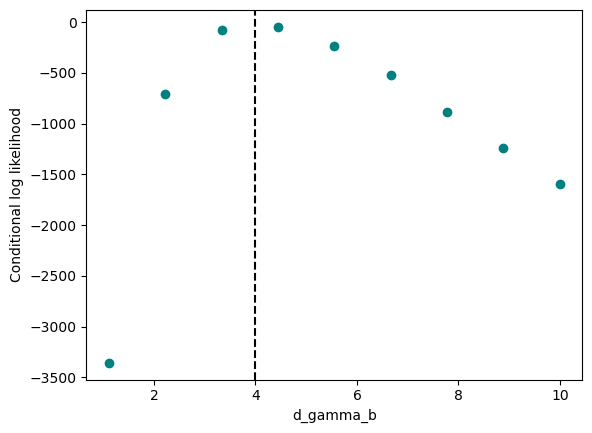

In [52]:
plt.figure()
plt.scatter(test_dgb,likes_dgb,color='teal')
plt.axvline(pop_theta['d_gamma_b'].get(),color='k',ls='--')
plt.xlabel("d_gamma_b")
plt.ylabel("Conditional log likelihood")
plt.show()

In [90]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [95]:
test_a = np.linspace(-1.5,1.5,10)

In [96]:
likes_a = []
for a in test_a:
    scan_theta['a_alpha'] = xp.array(a)
    likes_a.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

In [97]:
likes_a

[array(-629.34881636),
 array(-629.34881636),
 array(-268.40435431),
 array(-301.60727421),
 array(-88.71947697),
 array(-25.59418195),
 array(-5.07342128),
 array(-97.84058853),
 array(-3129.10017209),
 array(-3612.47556673)]

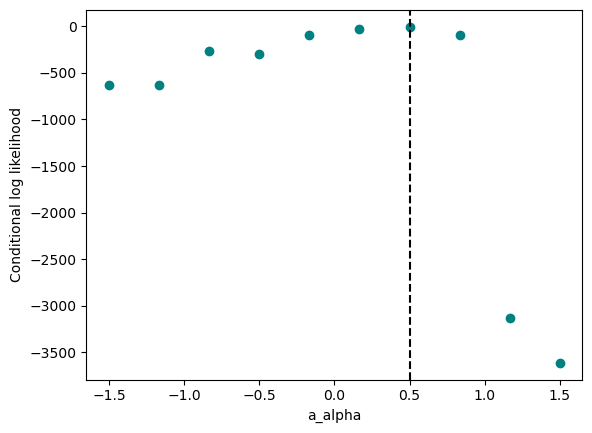

In [102]:
plt.figure()
plt.scatter(test_a,likes_a,color='teal')
plt.axvline(pop_theta['a_alpha'].get(),color='k',ls='--')
plt.xlabel("a_alpha")
plt.ylabel("Conditional log likelihood")
# plt.xlim(-1,1.5)
# plt.ylim(-500,0)
plt.show()

In [76]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1])}

In [77]:
fs, spec, N = test_popmodel.run_model(pop_theta=scan_theta)

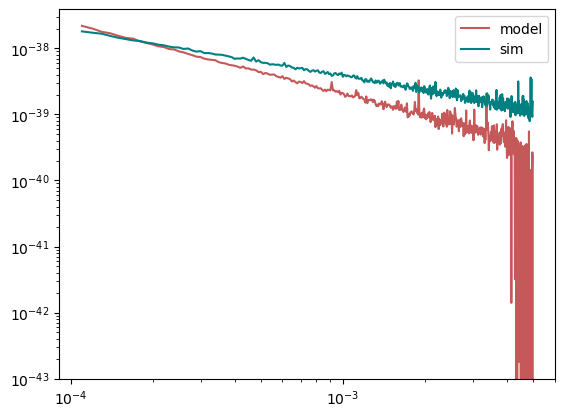

In [79]:
plt.figure()
plt.loglog(fs.get(), spec.get(),label='model',c='firebrick',alpha=0.75)
plt.loglog(test_f.get(),data_fg.get(),label='sim',c='teal')
plt.legend()
plt.show()

In [89]:
- xp.sum((spec-data_fg)**2)/(2*(1e-40)**2)

array(-47910.03850065)

In [88]:
- xp.sum((1e36*spec-1e36*data_fg)**2)/(2*1e36*1e-40)

array(-4.79100385)

In [32]:
test_rng = xp.random.default_rng(42)

In [33]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [34]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x776564377290>,
 'm_sigma': <distributions.invgamma at 0x7765643cce90>,
 'd_gamma_a': <distributions.uniform at 0x7765643cc0b0>,
 'd_gamma_b': <distributions.uniform at 0x7765643cd040>,
 'a_alpha': <distributions.uniform at 0x776564697530>}

In [35]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [36]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict)

In [37]:
## setup w.r.t. the data
datadict_2 = {'fg':data_fg,
            'fg_sigma':0.5, ## sigma_fg = 0.5 dex
            'Nres':data_N_res}

In [38]:
eryn_popmodel.construct_likelihood(datadict_2)

In [39]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [40]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [41]:
## MH with prior draws as the proposal function
PriorMove = DistributionGenerate({'model_0':eryn_prior})

In [42]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           moves=PriorMove,
                           track_moves=True,
                          )
                            # pool=pool)

In [43]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]

Log-likelihood:
 [ -26.00759713 -330.45894084 -191.56702824 -121.90170672 -282.810953
 -505.38074295 -355.3395393   -84.97043795  -29.90999366  -36.8920507 ]

Log-prior:
 [1.51918435 1.43631849 1.56719774 1.5512845  1.51950672 1.26510184
 1.33803885 1.03263569 1.5718752  1.55968188]


In [44]:
nsteps = 10
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

  0%|                                                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/inference.py:402: RuntimeWarning: divide by zero encountered in log10
  return self.array_gaussian_logpdf(xp.log10(theta_spec),xp.log10(self.mu_vec),self.cov)
/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/moves/move.py:515: RuntimeWarning: invalid value encountered in multiply
  temp_change_log_like = new_log_likes * (accepted_temp) + old_log_likes * (
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:29<00:00, 44.98s/it]


In [45]:
ensemble.acceptance_fraction

array([[0.1, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0.2, 0. , 0. ]])

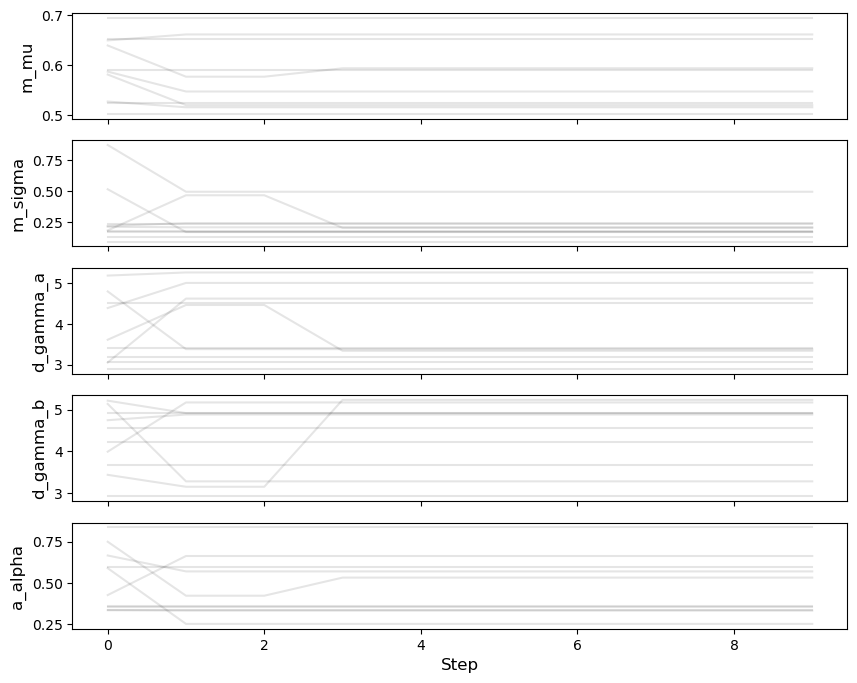

In [46]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

In [39]:
import scipy.stats as scst

In [44]:
st.poisson(test_rng,10000).logpmf(932),scst.poisson.logpmf(mu=10000,k=932)

(array(-6860.69465096), -6860.69465095916)

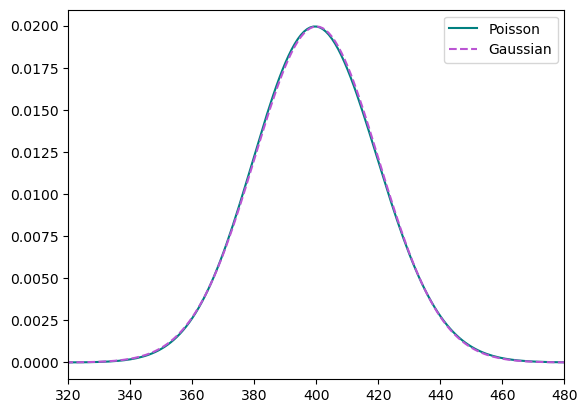

In [52]:
xs = np.arange(1,5001)
lam=400
plt.figure()
plt.plot(xs,scst.poisson.pmf(mu=lam,k=xs),color='teal',label='Poisson')
plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
plt.xlim(lam*0.8,lam*1.2)
plt.legend()
plt.show()

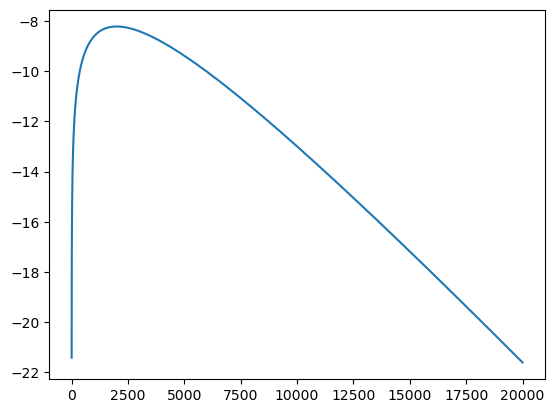

In [76]:
xs = np.arange(1,20001)
alpha = 3
beta = 1/1000
plt.figure()
plt.plot(xs,scst.gamma.logpdf(xs,a=alpha,scale=1/beta))
# plt.plot(xs,scst.poisson.pmf(mu=lam,k=xs),color='teal',label='Poisson')
# plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
# plt.xlim(lam*0.8,lam*1.2)
# plt.legend()
plt.show()

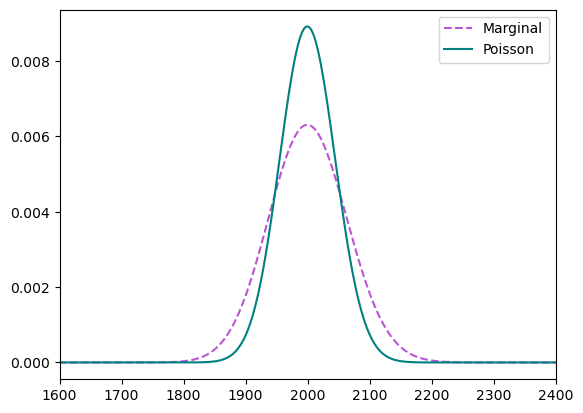

In [85]:
xs = np.arange(1,10001)

N_hat = 2000

alpha = 3
beta = 1/1000
n = alpha + N_hat
p = (beta+1)/(beta+2)
plt.figure()
plt.plot(xs,scst.nbinom.pmf(k=xs,n=n,p=p),color='mediumorchid',ls='--',label='Marginal')
plt.plot(xs,scst.poisson.pmf(mu=N_hat,k=xs),color='teal',label='Poisson')
# plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
plt.xlim(N_hat*0.8,N_hat*1.2)
plt.legend()
plt.show()

How sensitive are we to choice of alpha and beta?

In [94]:
from matplotlib import cycler
default_cycler=cycler(color=['navy','mediumorchid','teal','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)

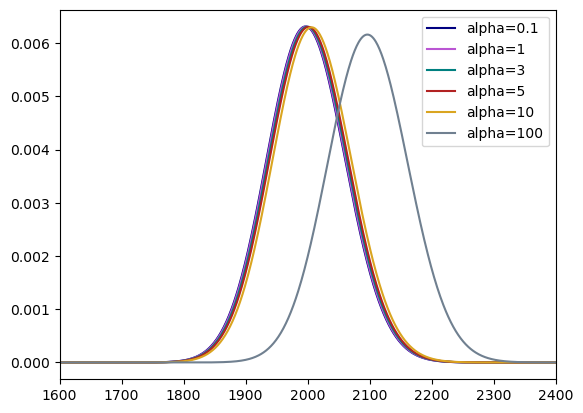

In [95]:
xs = np.arange(1,10001)

N_hat = 2000

plt.figure()

for alpha in [0.1,1,3,5,10,100]:
    beta = 1/1000
    n = alpha + N_hat
    p = (beta+1)/(beta+2)
    plt.plot(xs,scst.nbinom.pmf(k=xs,n=n,p=p),label='alpha={}'.format(alpha))
# plt.plot(xs,scst.poisson.pmf(mu=N_hat,k=xs),color='teal',label='Poisson')
# plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
plt.xlim(N_hat*0.8,N_hat*1.2)
plt.legend()
plt.show()

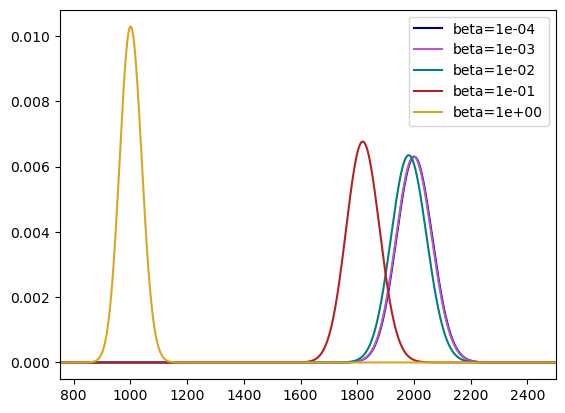

In [99]:
xs = np.arange(1,10001)

N_hat = 2000

plt.figure()

for beta in [1e-4,1e-3,1e-2,1e-1,1]:
    alpha = 3
    n = alpha + N_hat
    p = (beta+1)/(beta+2)
    plt.plot(xs,scst.nbinom.pmf(k=xs,n=n,p=p),label='beta={:0.0e}'.format(beta))
# plt.plot(xs,scst.poisson.pmf(mu=N_hat,k=xs),color='teal',label='Poisson')
# plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
# plt.xlim(N_hat*0.8,N_hat*1.2)
plt.xlim(750,2500)
plt.legend()
plt.show()

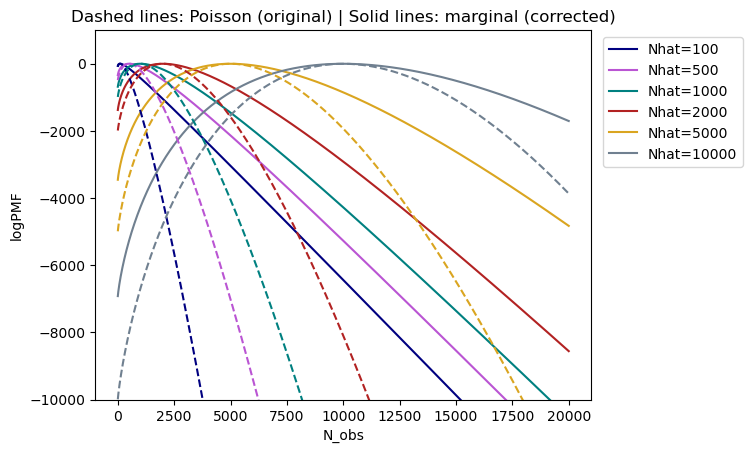

In [130]:
xs = np.arange(1,20001)
plt.figure()

for Nhat in [100,500,1000,2000,5000,10000]:
    alpha = 3
    beta = 1/1000
    n = alpha + Nhat
    p = (beta+1)/(beta+2)
    plt.plot(xs,scst.nbinom.logpmf(k=xs,n=n,p=p),label='Nhat={}'.format(Nhat))

for Nhat in [100,500,1000,2000,5000,10000]:
    alpha = 3
    beta = 1/1000
    n = alpha + Nhat
    p = (beta+1)/(beta+2)
    plt.plot(xs,scst.poisson.logpmf(mu=Nhat,k=xs),ls='--',label='__nolabel__')
# plt.plot(xs,scst.poisson.pmf(mu=N_hat,k=xs),color='teal',label='Poisson')
# plt.plot(xs,scst.norm.pdf(xs,loc=lam,scale=np.sqrt(lam)),color='mediumorchid',ls='--',label='Gaussian')
# plt.xlim(N_hat*0.8,N_hat*1.2)
# plt.xlim(0,100)
plt.ylim(-10000,1000)
plt.xlabel('N_obs')
plt.ylabel('logPMF')
plt.legend(bbox_to_anchor=(1.01,1))
plt.title('Dashed lines: Poisson (original) | Solid lines: marginal (corrected)')
plt.savefig('marginal_posson_gamma_vs_poisson.png',dpi=300,bbox_inches='tight')
plt.show()

In [36]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [37]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

In [42]:
eryn_popmodel.hpar_names

['m_mu', 'm_sigma', 'd_gamma_a', 'd_gamma_b', 'a_alpha']

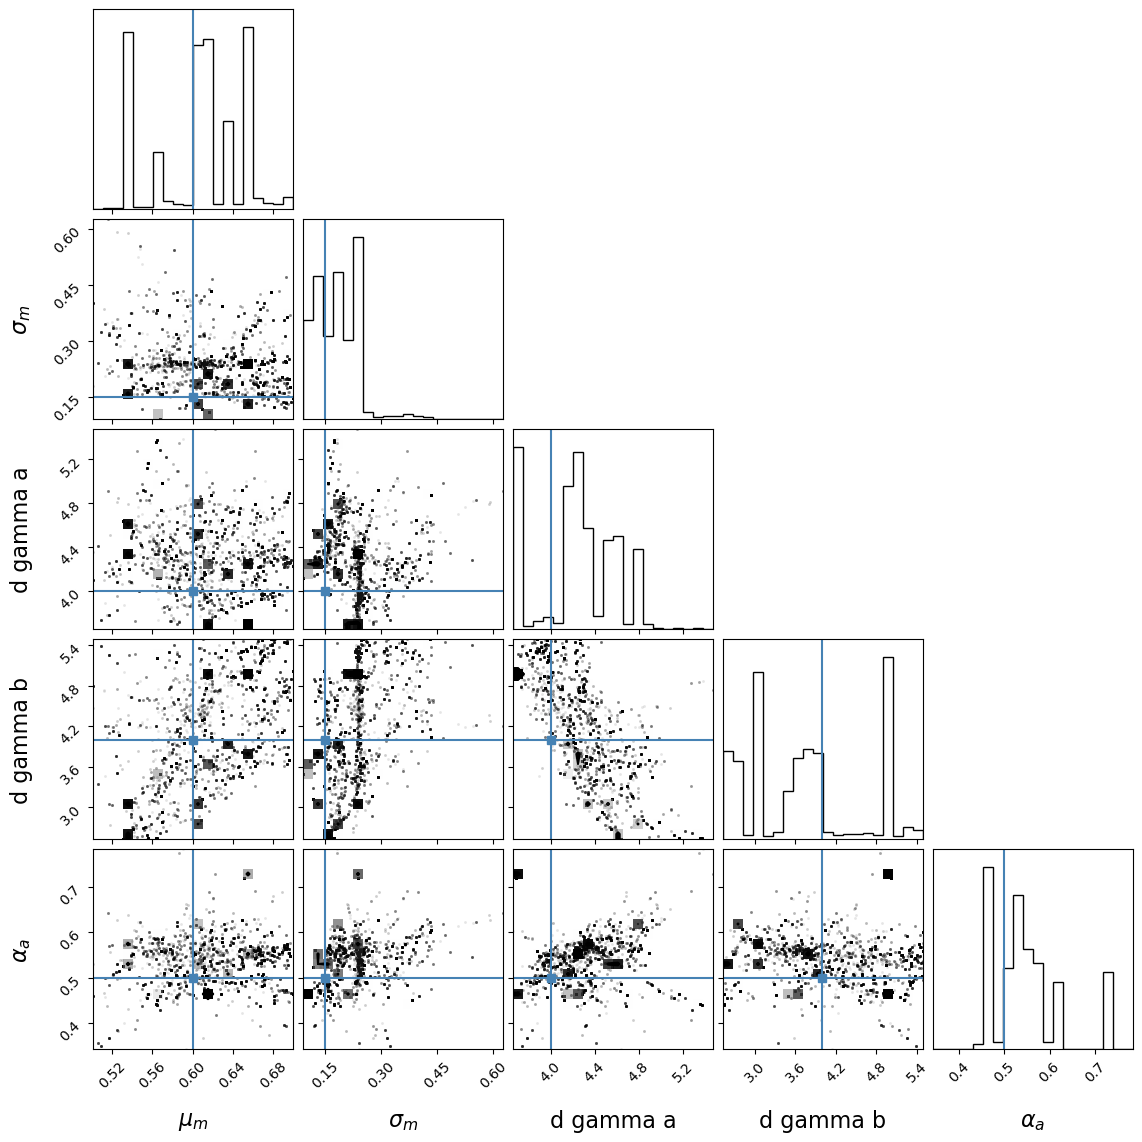

In [39]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

As before, lots of stuck chains. Let's check the problem ones:

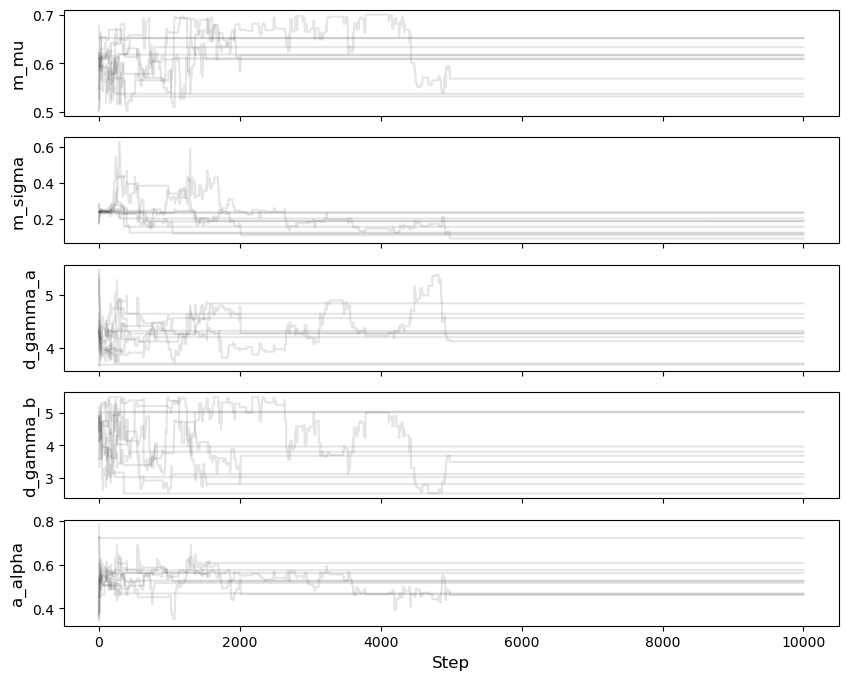

In [43]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
plt.savefig('chain_plots_full.png')
plt.show()

In [46]:
burned_samples = ensemble.get_chain()['model_0'][5000:]
burned_samples.shape

(5000, 1, 10, 1, 5)

In [47]:
## trim the stuck chains
trimmed_samples = burned_samples[::2,...]
trimmed_samples.shape

(2500, 1, 10, 1, 5)

In [52]:
chain_vars = np.var(trimmed_samples,axis=0)
chain_vars.shape

(1, 10, 1, 5)

In [53]:
chain_vars = chain_vars.reshape(10,5)

In [54]:
chain_vars

array([[3.73180512e-28, 2.27906846e-29, 1.91977190e-26, 6.63432021e-28,
        1.63010710e-28],
       [1.57390077e-28, 3.56220003e-30, 6.18466950e-26, 1.66922968e-27,
        1.11241714e-28],
       [3.94935817e-28, 3.52799551e-29, 2.12172029e-26, 6.31790810e-26,
        5.85778526e-28],
       [7.51993984e-28, 5.50064851e-30, 1.96931236e-26, 1.42488001e-27,
        2.49600521e-31],
       [7.39865247e-28, 1.03661253e-29, 6.67691870e-27, 1.50230671e-26,
        5.33269972e-28],
       [8.14116780e-28, 9.06334928e-29, 1.33317493e-28, 4.28264697e-26,
        1.94136820e-28],
       [1.41119820e-28, 4.91160284e-29, 3.28292354e-26, 6.38977333e-27,
        1.28239201e-28],
       [1.25430117e-27, 2.20499719e-30, 1.87086252e-26, 7.96769236e-27,
        1.20806652e-28],
       [6.86506203e-28, 4.32710236e-29, 5.33269972e-26, 4.26162383e-27,
        4.89217021e-29],
       [9.54521695e-29, 1.46709639e-29, 7.48345009e-26, 8.45047523e-27,
        5.43574468e-28]])

In [55]:
stuck_filt = np.prod(chain_vars < 1e-7,axis=1,dtype='bool')

In [56]:
stuck_filt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [501]:
trimmed_samples = trimmed_samples[...,np.invert(stuck_filt),:,:]

In [502]:
trimmed_samples.shape

(350, 1, 12, 1, 5)

In [503]:
trimmed_samples_sep = trimmed_samples
trimmed_samples = trimmed_samples.reshape(-1,ndim)

In [504]:
trimmed_samples.shape

(4200, 5)